In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import json
from collections import Counter
import powerlaw
from itertools import combinations
import random

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


## 1. Load the data & create the network

In [2]:
# targets
targets_df = pd.read_csv('./lastfm_asia/lastfm_asia_target.csv')

# features
with open('./lastfm_asia/lastfm_asia_features.json', 'r') as file:
    features = json.load(file)

# edge list
edge_df = pd.read_csv('./lastfm_asia/lastfm_asia_edges.csv', delimiter=',')

In [3]:
edge_df.head()

,node_1,node_2
0,0,747
1,1,4257
2,1,2194
3,1,580
4,1,6478


In [4]:
# create the network from the edge list
G = nx.from_pandas_edgelist(edge_df, source='node_1', target='node_2')

In [5]:
# load the features for each node
for node, feature in features.items():
    G.nodes[int(node)]['artists'] = feature

In [6]:
# basic info about the network
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("First few rows of targets:\n", targets_df.head())

Number of nodes: 7624
Number of edges: 27806
First few rows of targets:
    id  target
0   0       8
1   1      17
2   2       3
3   3      17
4   4       5


## 2. Visualize the network

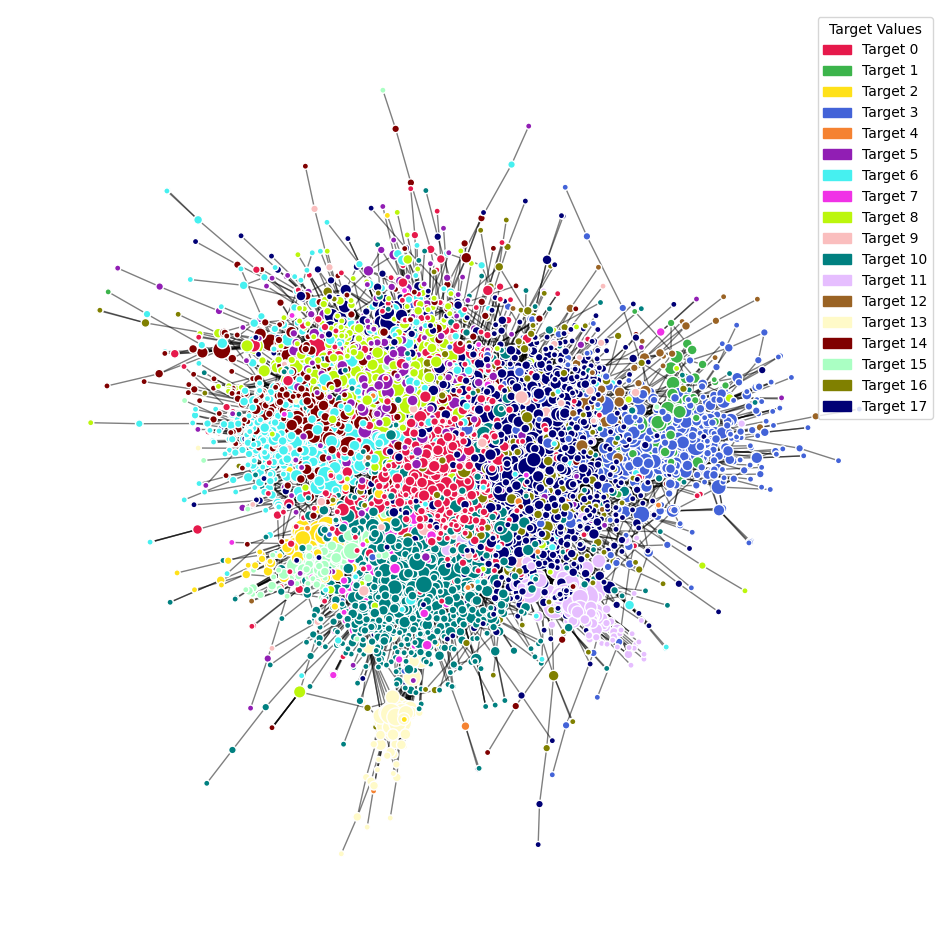

In [8]:
# plot the network
plt.figure(figsize=(12, 12))

# node position
pos = nx.spring_layout(G)

# get node's degree
n_deg = dict(G.degree())

# node size proportional to degree
sizes = [10*n_deg[node]+10 for node in G.nodes()]
# node color based on target
unique_targets = sorted(targets_df['target'].unique())

# Define a list of vibrant colors manually
vibrant_colors = [
    "#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#46f0f0",
    "#f032e6", "#bcf60c", "#fabebe", "#008080", "#e6beff", "#9a6324", "#fffac8",
    "#800000", "#aaffc3", "#808000", "#000075"
]

# Map each target to a color from the vibrant list
target_colors = {target: vibrant_colors[i % len(vibrant_colors)] for i, target in enumerate(unique_targets)}

# Assign colors to nodes based on target values
colors = [target_colors[targets_df.loc[targets_df['id'] == int(node), 'target'].values[0]] for node in G.nodes()]
# draw nodes
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, edgecolors='#ffffff', cmap=plt.cm.Set1)
# draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Create legend
legend_patches = [mpatches.Patch(color=target_colors[target], label=f'Target {target}') for target in unique_targets]
plt.legend(handles=legend_patches, loc='upper right', title="Target Values")

plt.axis('off')

# Save the plot to an image file
plt.savefig("lastfm_network_visualization.png", format="png", dpi=300)  # Save as PNG with high resolution
plt.show()

## 3. Network Structure analysis

### 3.1. Average clustering coefficient and average shortest path length

In [9]:
# calculate the average clustering coefficient and average shortest path length
C = nx.average_clustering(G)
L = nx.average_shortest_path_length(G)

print(f'Average clustering coefficient: {C:.4f}')
print(f'Average shortest path length: {L:.4f}')

Average clustering coefficient: 0.2194
Average shortest path length: 5.2322


### 3.2. Degree distribution - Scale-free network

Let's plot the degree probability mass function

In [9]:
deg_distribution = Counter(n_deg.values())

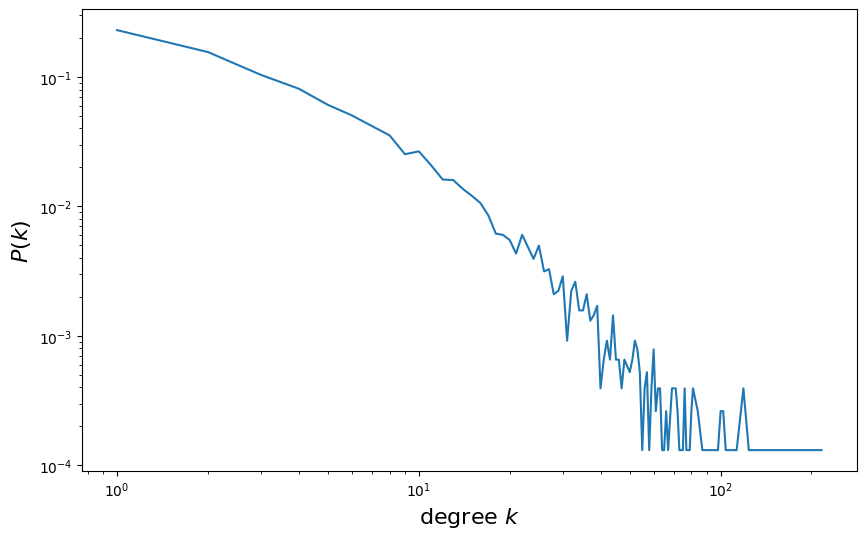

In [10]:
x = []
y = []

for i in sorted(deg_distribution):
    x.append(i)
    y.append(deg_distribution[i] / len(G))

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel('degree $k$', fontsize=16)
plt.ylabel('$P(k)$', fontsize=16)
plt.yscale('log')
plt.xscale('log')
# plt.axis([1,1000,0.00001,0.2])
plt.savefig('probability_mass_function.png', format="png", dpi=300)
plt.show()

Probability density distribution

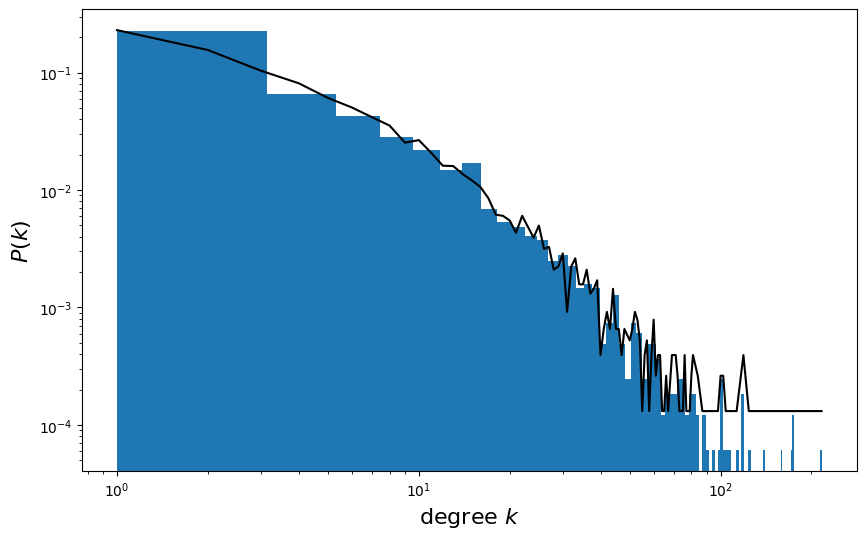

In [11]:
plt.figure(figsize=(10,6))

plt.hist(n_deg.values(), bins=100, density=True, log=True, histtype='stepfilled')

plt.plot(x,y,'black','o')
plt.xscale('log')
plt.yscale('log')
# plt.xticks(fontsize=20)
# plt.yticks(f)
plt.xlabel('degree $k$', fontsize=16)
plt.ylabel('$P(k)$', fontsize=16)
plt.savefig('probability_density_function.png', format="png", dpi=300)
plt.show()

Let's see if the degree distribution follows a power-law distribution.

In [12]:
# fit a power law distribution
pwl_fit = powerlaw.Fit(data=list(n_deg.values()))

print(f'Power law distribution alpha: {pwl_fit.power_law.alpha:.4f}')
print(f'Power law distribution sigma: {pwl_fit.power_law.sigma:.4f}')

Calculating best minimal value for power law fit
Power law distribution alpha: 3.3263
Power law distribution sigma: 0.1359


We can look at the values of the Kolgomorov-Sminorv distance of the two fits to compare them. Smaller distances correspond to better fits.

In [14]:
observed_D = pwl_fit.power_law.D
print(f'Observed KS statistic: {observed_D:.4f}')

Observed KS statistic: 0.0503


Run a bootstrap test on the KS statistic to check whether the observed statistic falls within the distribution of KS statistics from the bootstrap samples.

In [39]:
# generate the 1000 bootstrap samples of size equal to number of nodes in G
np.random.seed(101)
B = 1000    # number of bootstrap samples
alpha = pwl_fit.power_law.alpha     # estimated alpha obtained from powerlaw fit above
bootstrap_samples = np.random.choice(np.array(list(n_deg.values())), size=(B, len(G.nodes())), replace=True)

# fit power law to each bootstrap sample and calculate the KS statistic
bootstrap_D = np.array([powerlaw.Fit(sample).D for sample in bootstrap_samples])

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

In [45]:
# calculate the confidence interval of the bootstrap KS statistics
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

lower_bound = np.percentile(bootstrap_D, lower_percentile)
upper_bound = np.percentile(bootstrap_D, upper_percentile)

print('bootstrap mean D statistic score = %.4f (i.e., mean of the B bootstrap estimates)' %bootstrap_D.mean())
print('bootstrap 95%% CI = (%.4f, %.4f)' %(lower_bound, upper_bound))

bootstrap mean D statistic score = 0.0495 (i.e., mean of the B bootstrap estimates)
bootstrap 95% CI = (0.0362, 0.0612)


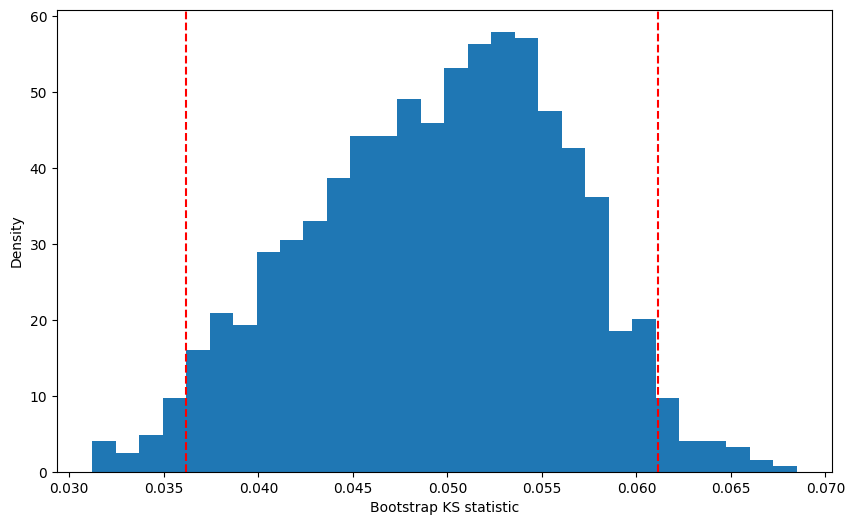

In [62]:
# plot the histogram of bootstrap D statistics and the 95% CI
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_D, bins=30, density=True)
plt.axvline(lower_bound, linestyle='--', color='r')
plt.axvline(upper_bound, linestyle='--', color='r')
plt.xlabel('Bootstrap KS statistic')
plt.ylabel('Density')
plt.savefig('bootstrap_ks_stat.png', format="png")
# plt.tight_layout()
plt.show()

The observed D statistic falls within the 95% confidence interval, meaning that the power-law fit is reasonable.

Let's see which distribution provides a better fit for the data than the power-law distribution.

In [72]:
candidate_distributions = ['power_law', 'truncated_power_law', 'lognormal', 'exponential']
comparison_result = []

for dist1, dist2 in combinations(candidate_distributions, 2):
    R, p = pwl_fit.distribution_compare(dist1, dist2, nested=False)
    comparison_result.append((dist1, dist2, R, p))

comparison_result = pd.DataFrame(comparison_result, columns=['distribution_1', 'distribution_2', 'loglikelihood_ratio', 'p_value'])

comparison_result.to_csv('dist_comparison.csv', index=False)

Assuming nested distributions


In [73]:
comparison_result

,distribution_1,distribution_2,loglikelihood_ratio,p_value
0,power_law,truncated_power_law,-2.015032,0.044696
1,power_law,lognormal,-1.498698,0.276950
2,power_law,exponential,9.395554,0.144588
3,truncated_power_law,lognormal,0.516334,0.041487
4,truncated_power_law,exponential,11.410587,0.024377
5,lognormal,exponential,10.894252,0.033522


Let's also plot the probability density function of the degrees against the pdf of some candidate distributions

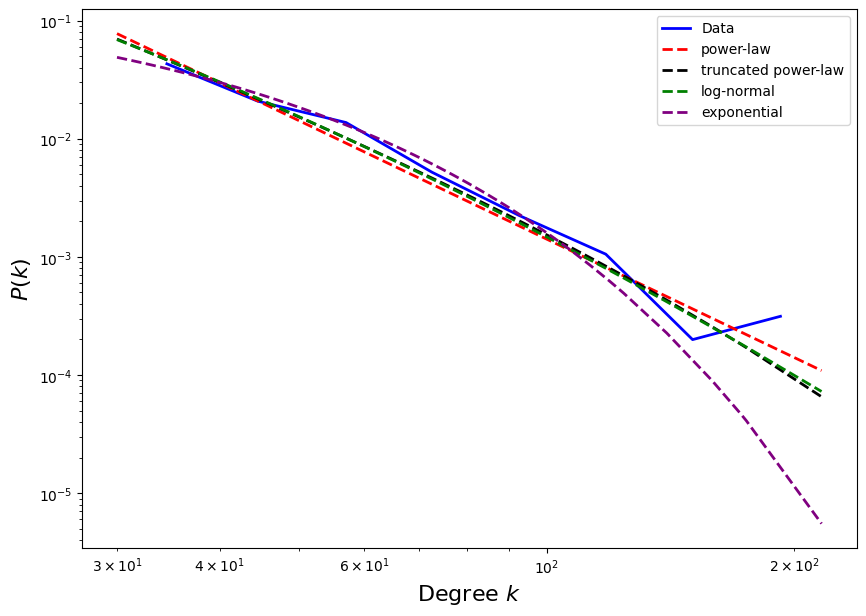

In [63]:
fig=plt.figure(figsize=(10,7))

fig=powerlaw.plot_pdf([x for x in n_deg.values() if x>pwl_fit.power_law.xmin], color='b', linewidth=2, label='Data')

pwl_fit.power_law.plot_pdf(ax=fig, color='red', linestyle='--', linewidth=2, label='power-law')
pwl_fit.truncated_power_law.plot_pdf(ax=fig, color='black', linestyle='--', linewidth=2, label='truncated power-law')
pwl_fit.lognormal.plot_pdf(ax=fig, color='green', linestyle='--', linewidth=2, label='log-normal')
pwl_fit.exponential.plot_pdf(ax=fig, color='purple', linestyle='--', linewidth=2, label='exponential')


fig.legend()
plt.xlabel('Degree $k$', fontsize=16)
plt.ylabel('$P(k)$', fontsize=16)
plt.savefig('pdf_fit.png', format="png")
plt.show()